In [1]:
include("OQS_Tools_v1.jl")
using Plots
using ITensors
using ITensorMPS
using LinearAlgebra
using PolyChaos
using .OQS_Tools_v1
BLAS.set_num_threads(4)
ITensors.enable_threaded_blocksparse(false)

false

In [2]:
D = 5.0 #bandwidth
bath_shape = "elliptical" #bath spectral density shape
g = 0.1 #system-bath coupling
N = 50 #number of bath sites
beta = 10.0 #inverse temperature
mu = 0.0 #chemical potential
Esys = 0.0 #system onsite energy
sys = N+1
sys_occ = 0.0 #system initial occupation
dt = 0.1 #time step
tmax = 50.0 #maximum time

50.0

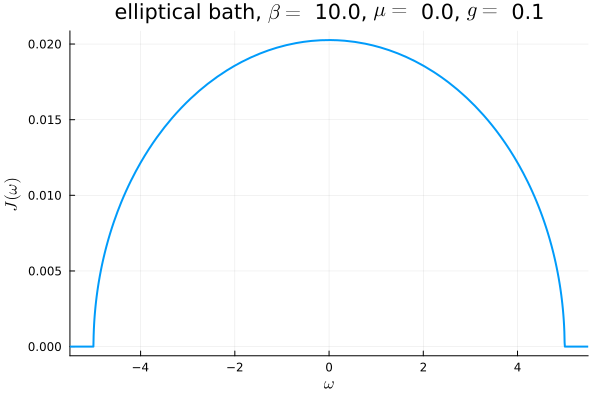

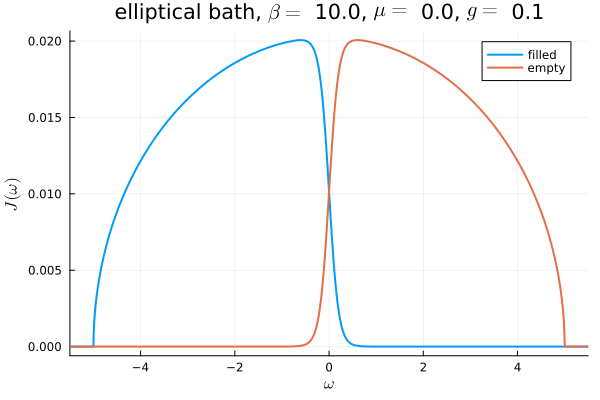

([2.1178829174770013, 2.406501975831696, 2.408356247357952, 2.361169565592062, 2.2912156917858257, 2.2047004288631107, 2.1046657950309187, 1.9932767756750547, 1.8723221730057575, 1.743481779376495  …  1.1523351215739688, 1.15239765270004, 1.1524591801005077, 1.1525200218971274, 1.1525804498618972, 1.1526406941226321, 1.1527009481797383, 1.152761376670436, 1.1528221242347423, 1.1528833216340089], [0.2820947916598008, 1.3283719157533198, 1.2911383077369545, 1.3058314714713697, 1.3357110230110467, 1.3750538444448275, 1.421832019570126, 1.4747977156123182, 1.5329795482698547, 1.5955306442993895  …  1.9238483089685283, 1.9238167242022584, 1.9237857308449973, 1.9237551567135385, 1.923724854714835, 1.9236946996260054, 1.9236645859355987, 1.9236344246692079, 1.9236041390217165, 1.9235736603713744])

In [3]:
J = create_spectral(bath_shape, D, g)
display(plot(J,xlabel="\$ \\omega \$", ylabel="\$ J(\\omega) \$", title="$bath_shape bath, \$\\beta=\$ $beta, \$ \\mu=\$ $mu, \$g=\$ $g", label="", lw=2, xlims=(-1.1D,1.1D)))
J1, J2 = thermofield_transform(J, beta, mu)
p = plot(J1,xlabel="\$ \\omega \$", ylabel="\$ J(\\omega) \$", title="$bath_shape bath, \$\\beta=\$ $beta, \$ \\mu=\$ $mu, \$g=\$ $g", label="filled", lw=2, xlims=(-1.1D,1.1D))
plot!(p, J2, label="empty", lw=2)
display(p)
E1, h1 = chain_map(J1, N, D)
E2, h2 = chain_map(J2, N, D)


In [9]:
H_mat = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
C0 = prepare_correlations(N, sys_occ)

#psi0, sites, states = prepare_MPS(N, sys_occ)
#H_mpo = make_H_mpo(E1, E2, h1, h2, sites, Esys, N, sys)

DimensionMismatch: DimensionMismatch: array could not be broadcast to match destination

In [5]:
ts = collect(dt:dt:tmax)
nSys_exact = zeros(length(ts))

#psi, nSys_mps = evolve_MPS_1(psi0, H_mpo, sys, dt, tmax)
nSys_exact .= evolve_correlations.(C0, H_mat, ts, N)[N+1,N+1]

p = plot(ts, nSys_exact, xlabel="Time", ylabel="Occupation", title="$bath_shape bath, \$\\beta=\$ $beta, \$ \\mu=\$ $mu, \$g=\$ $g", c=:blue, label="Exact", lw=2)
#plot!(p, nSys_mps, label="MPS", c=:red, lw=2)

UndefVarError: UndefVarError: `C0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [6]:
#psi, nSys_mps = evolve_MPS(psi0, H_mpo, sys, dt, tmax)

#c = cgrad([:blue, :green], [-0.5,0.0,1.0])
anim = @animate for t in dt:dt:tmax
        C = evolve_correlations(C0, H_mat, t, N)
        p = heatmap(abs.(C), title="Time = $t", xlabel="Site Index", ylabel="Site Index", color=:viridis, clim=(0.0,1.0))
        end
gif(anim, "corr_evolution_chain.gif", fps=30)


UndefVarError: UndefVarError: `C0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [7]:
nSys = zeros(2N+1, 2N+1)
anim = @animate for t in dt:dt:tmax
     C = evolve_correlations(C0, H_mat, t, N)
     nSys = diag(C)
     plot(-N:N, real(nSys), title="Time", xlabel="Chain Site", ylabel="Occupation", lw=2, label="")
    end
gif(anim, "nSys.gif", fps=30)

UndefVarError: UndefVarError: `C0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
#exact solution in star basis

fermi = k -> 1 / (1 + exp(beta*(k - mu)))

N = 500
omegas = collect(range(-D,D,N))
fs = zeros(N)
fs = fermi.(omegas)
couplings = zeros(N)
couplings .= sqrt.(J.(omegas)) ./ sqrt(N)
H = zeros(N+1, N+1)
H[2:end,1] .= couplings
H[1,2:end] .= couplings
H[diagind(H)[2:end]] .= omegas

C0 = zeros(N+1, N+1)
C0[diagind(C0)[2:end]] .= fs

function evolve(t)
    U = exp(-im * t * H)
    C = U * C0 * U'
    return C
end




evolve (generic function with 1 method)